#### **Lens Model**

**DESIJ0136-0008**

**Author:** Sulyman Hossain, Fahim Rajit Hossain, Akbar, Anowar Shajib

**Acknowledgement:** Mir Sazzat Hossain, S M Rafee Adnan

In [1]:
# make sure lenstronomy is installed, otherwise install the latest pip version
# import of standard python libraries
import corner
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

!pip install lenstronomy
!pip install emcee
!pip install corner


%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for lenstronomy: filename=lenstronomy-1.11.5-py3-none-any.whl size=1139065 sha256=73d46be46820d82222cf8e52c40a48cefd36417e87b70aa20f41666e4b7a8e61
  Stored in directory: /root/.cache/pip/wheels/78/dd/d9/bbdd80cec79b57ec559b7183476b0e8802a2c029e312d05b0f
  Created wheel for schwimmbad: filename=schwimmbad-0.3.2-py3-none-any.whl size=15729 sha256=1efa1418fe19b7253a2f49ae152be74c2cc2fd3b86b8a075bb0c8985da4b8bcf
  Stored in directory: /root/.cache/pip/wheels/4a/ea/3e/b79646d96eaea548b8eec6d2caed656a3c7f17ce5f264484b8
Successfully b

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
"""src_path = r"/kaggle/input/akbars-output-filesfinal/mcmc_backend.h5"
dst_path = r"/kaggle/working/"
shutil.copy(src_path, dst_path)"""

'src_path = r"/kaggle/input/akbars-output-filesfinal/mcmc_backend.h5"\ndst_path = r"/kaggle/working/"\nshutil.copy(src_path, dst_path)'

## Loading data for Model

In [3]:
with h5py.File("/kaggle/input/akbar-data/DESIJ0136-0008_F140W.h5", "r") as f:
    kwargs_data = {}

    for key in f:
        if key == "exposure_time":
            kwargs_data[key] = f[key][()]
            continue
        kwargs_data[key] = f[key][()]

# print kwargs_data
for key in kwargs_data:
    print(f"{key}: {kwargs_data[key]}")

background_rms: 0.020226480636773847
dec_at_xy_0: -10.03999999999999
exposure_time: [[480.17502 478.00955 545.1479  ... 453.76492 495.06876 351.65335]
 [539.82275 396.43954 378.49487 ... 577.67755 321.1616  305.41653]
 [347.75266 582.9625  483.96677 ... 425.66187 318.69778 337.77414]
 ...
 [431.28677 453.53516 507.60822 ... 417.27905 406.37323 441.34796]
 [373.92175 272.3933  383.2737  ... 431.20264 502.59534 595.19434]
 [392.85666 451.82388 520.1835  ... 609.24677 391.4596  412.2425 ]]
image_data: [[-0.01320017  0.00887198  0.01452675 ... -0.00496921 -0.00073036
   0.01501495]
 [-0.008774    0.02328778  0.00136724 ... -0.04160036  0.0106275
   0.00662912]
 [-0.03182266 -0.00972193  0.00459631 ... -0.01573473  0.0048767
   0.00191049]
 ...
 [ 0.00095618  0.01111637  0.00379965 ...  0.01628057  0.00888098
  -0.01454695]
 [ 0.00781532 -0.00317025  0.01218377 ...  0.00941897 -0.00657219
  -0.0251791 ]
 [ 0.00606052  0.00711807  0.01721074 ...  0.05797264 -0.00717967
  -0.02253795]]
ra_at_

In [4]:
with h5py.File("/kaggle/input/akbar-data/psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"
print(kwargs_psf)

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
        3.2385867e-06, 4.4331632e-06],
       [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
        6.6143798e-06, 4.1430776e-06],
       [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
        5.1404800e-06, 1.7530243e-06],
       ...,
       [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
        5.3933368e-06, 1.6360833e-06],
       [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
        8.7221979e-06, 3.7005334e-06],
       [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
        3.2246478e-06, 5.1252514e-06]], dtype=float32), 'psf_type': 'PIXEL'}


/tmp/ipykernel_21/2469112303.py:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


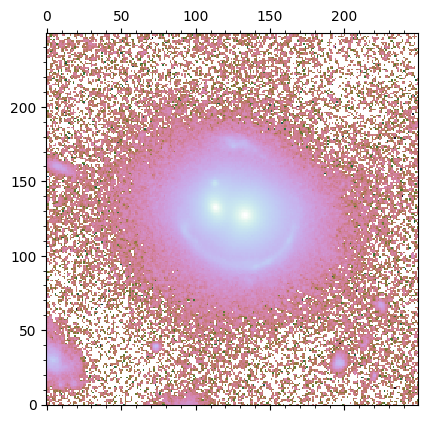

In [5]:
image_data = kwargs_data["image_data"]
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
# plt.grid(which="both", color="black")
plt.minorticks_on()
# plt.grid(which="minor", color="black")


# plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');

### Masking

/tmp/ipykernel_21/2279094133.py:96: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image_data), origin="lower", cmap="cubehelix")
/tmp/ipykernel_21/2279094133.py:108: RuntimeWarning: divide by zero encountered in log10
  image_after_mask = np.log10(image_data * mask)
/tmp/ipykernel_21/2279094133.py:108: RuntimeWarning: invalid value encountered in log10
  image_after_mask = np.log10(image_data * mask)


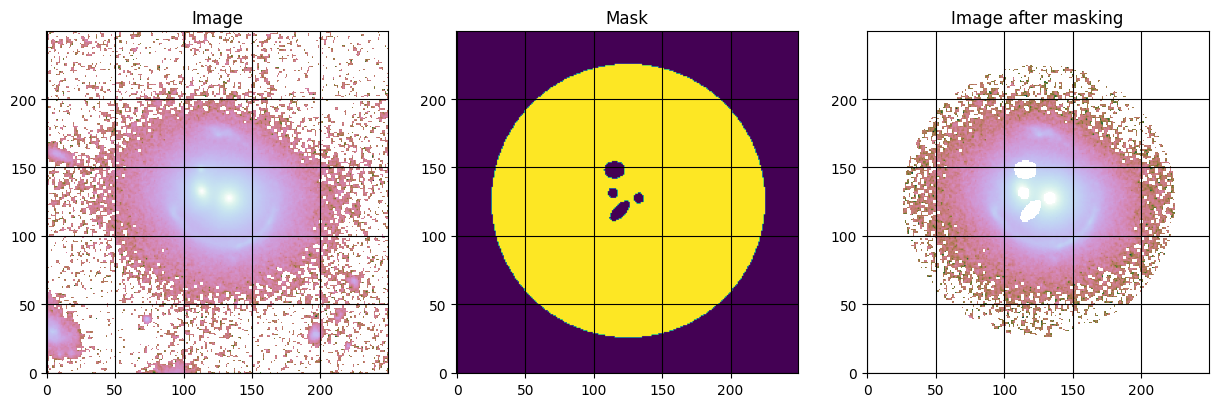

In [6]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 8  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


# for the galaxy at 11 o clock
mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.8,
    lens_center_dec + 1.8,
    0.6,
    0.5,
    0,
)

# for the blob at 12 o clock
mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5,
    lens_center_dec + 4,
    2,
    1,
    np.pi + 0.3,
)

# EPL Center
mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.62,
    lens_center_dec + 0.153,
    0.3,
    0.3,
    0,
)

# Satellite Center
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.9,
    lens_center_dec + 0.45,
    0.3,
    0.3,
    0,
)

# For removing the extra light
mask_ext_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.5,
    lens_center_dec - 0.6,
    0.35,
    0.75,
    0.78,
)


mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    # * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
    * (1 - mask_ext_5)
)
mask[mask >= 1] = 1
mask[mask < 0] = 0
mask = mask.reshape(num_pix, num_pix)


# Setting the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(np.log10(image_data), origin="lower", cmap="cubehelix")
axes[0].grid(True, color="black")
# axes[0].minorticks_on()
# axes[0].grid(which='minor', color='black')
axes[0].set_title("Image")


axes[1].imshow(mask, origin="lower")
axes[1].grid(True, color="black")
axes[1].set_title("Mask")


image_after_mask = np.log10(image_data * mask)

axes[2].imshow(image_after_mask, origin="lower", cmap="cubehelix")
axes[2].grid(True, color="black")
axes[2].set_title("Image after masking")


# Show the plots
plt.show()

In [7]:
lens_model_list = ["EPL", "SHEAR", "SIE"]
source_model_list = [
    "SERSIC_ELLIPSE",
    "SHAPELETS",
    #                     "SHAPELETS",
]
lens_light_model_list = [
    "SERSIC_ELLIPSE",
    "SERSIC_ELLIPSE",
    "SERSIC_ELLIPSE",
]

## Lens galaxy's mass model

In [8]:
# Lens parameter

# EPL 1

lens_center_x = -0.621  # -0.64280
lens_center_y = 1.61  # 0.153813
lens_centroid_bound = 1

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})

kwargs_lens_init.append(
    {
        "theta_E": 3.23,
        "gamma": 2,
        "e1": -0.20,
        "e2": 0.1276,
        "center_x": -0.235,
        "center_y": 1.270,
    }
)

kwargs_lens_sigma.append(
    {
        "theta_E": 0.3,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": lens_centroid_bound / 4,
        "center_y": lens_centroid_bound / 4,
    }
)

kwargs_lower_lens.append(
    {
        "theta_E": 2.0,
        "gamma": 1.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": lens_center_x - lens_centroid_bound,
        "center_y": lens_center_y - lens_centroid_bound,
    }
)

kwargs_upper_lens.append(
    {
        "theta_E": 5.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": lens_center_x + lens_centroid_bound,
        "center_y": lens_center_y + lens_centroid_bound,
    }
)

# SHEAR


fixed_lens.append({"ra_0": 0.0, "dec_0": 0.0})  # Shear
kwargs_lens_init.append(
    {"gamma1": -0.101, "gamma2": 0.1005, "ra_0": 0.0, "dec_0": 0.0}  # 0.0
)  # 0.0

kwargs_lens_sigma.append(
    {"gamma1": 0.05, "gamma2": 0.05, "ra_0": 0.1, "dec_0": 0.1}
)  # Changed

kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3, "ra_0": -10, "dec_0": -10})

kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3, "ra_0": 10, "dec_0": 10})

### SIE left one

In [9]:
# SIE parameter

satellite_center_x = 0.956
satellite_center_y = 0.552
satellite_centroid_bound = 0.5

fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 0.91,
        "e1": -0.1203,
        "e2": 0.0605,  # 0.16
        "center_x": satellite_center_x,
        "center_y": satellite_center_y,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": satellite_centroid_bound / 4,
        "center_y": satellite_centroid_bound / 4,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.0001,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": satellite_center_x - satellite_centroid_bound,
        "center_y": satellite_center_y - satellite_centroid_bound,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 5.0,  # 2.0
        "e1": 0.5,
        "e2": 0.5,
        "center_x": satellite_center_x + satellite_centroid_bound,
        "center_y": satellite_center_y + satellite_centroid_bound,
    }
)

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

## Source galaxy's light model

In [10]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

source1_bound = 0.5
source1_x = -0.5  # 1
source1_y = +4.0  # 1.8


fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.15,
        "n_sersic": 1.0,
        "e1": -0.4798,
        "e2": -0.0135,
        "center_x": source1_x,
        "center_y": source1_y,
        "amp": 10,
    }
)

kwargs_source_sigma.append(
    {
        "R_sersic": 0.1,
        "n_sersic": 0.5,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": source1_bound / 4,
        "center_y": source1_bound / 4,
        "amp": 10,
    }
)

kwargs_lower_source.append(
    {
        "R_sersic": 0.0001,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": source1_x - source1_bound,
        "center_y": source1_y - source1_bound,
        "amp": 0,
    }
)

kwargs_upper_source.append(
    {
        "R_sersic": 0.3,
        "n_sersic": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": source1_x + source1_bound,
        "center_y": source1_y + source1_bound,
        "amp": 100,
    }
)

## Shapelets

In [11]:
# 1st Shapelets


fixed_source.append({"n_max": 10})
kwargs_source_init.append({"beta": 0.1, "center_x": source1_x, "center_y": source1_y})

kwargs_source_sigma.append(
    {"beta": 0.05, "center_x": source1_bound / 4, "center_y": source1_bound / 4}
)

kwargs_lower_source.append(
    {
        "beta": 0.001,  # 0.1
        "center_x": source1_x - source1_bound,
        "center_y": source1_y - source1_bound,
    }
)

kwargs_upper_source.append(
    {
        "beta": 0.25,
        "center_x": source1_x + source1_bound,
        "center_y": source1_y + source1_bound,
    }
)

joint_shapelets_with_sersic = [[0, 1, ["center_x", "center_y"]]]


"""# 2nd Shapelets

source2_bound = 0.5
source2_x = -0.5   # -0.5
source2_y = +4.0   # -2
fixed_source.append({"n_max": 10})
kwargs_source_init.append({"beta": 0.05,
                           "center_x":  source2_x,
                           "center_y":  source2_y})

kwargs_source_sigma.append({"beta": 0.05,
                            "center_x": source2_bound/4,
                            "center_y": source2_bound/4})

kwargs_lower_source.append({"beta": 0.001,  #0.1
                            "center_x": source2_x - source2_bound,
                            "center_y": source2_y - source2_bound})

kwargs_upper_source.append({"beta": 0.15,
                            "center_x": source2_x + source2_bound,
                            "center_y": source2_y + source2_bound})"""

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

## Lens galaxy Light Model

In [12]:
# Lens Galaxy

# 1st Sersic

fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 1.9800,
        "n_sersic": 1.0,
        "e1": 0.214,
        "e2": 0.0519,
        "center_x": -0.65044,
        "center_y": 0.149,
        "amp": 16,
    }
)


kwargs_lens_light_sigma.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)

kwargs_lower_lens_light.append(
    {
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_upper_lens_light.append(
    {
        "R_sersic": 10,
        "n_sersic": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# 2nd sersic ellipse params

fixed_lens_light.append({"n_sersic": 4.0})


kwargs_lens_light_init.append(
    {
        "R_sersic": 0.631,
        "n_sersic": 4.0,
        "e1": -0.034,
        "e2": 0.027,
        "center_x": -0.6504,
        "center_y": 0.14983,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.4,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# Satellite Galaxy

# 3rd Sersic

fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 0.448,
        "n_sersic": 4,
        "e1": -0.1150,
        "e2": 0.068,
        "center_x": satellite_center_x,
        "center_y": satellite_center_y,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": satellite_centroid_bound / 4,
        "center_y": satellite_centroid_bound / 4,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": satellite_center_x - satellite_centroid_bound,
        "center_y": satellite_center_y - satellite_centroid_bound,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": satellite_center_x + satellite_centroid_bound,
        "center_y": satellite_center_y + satellite_centroid_bound,
        "amp": 100,
    }
)


joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]
joint_lens_with_light = [
    #                        [0, 0, ["center_x", "center_y"]],
    [2, 2, ["center_x", "center_y", "e1", "e2"]],
]


lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

In [13]:
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_shapelets_with_sersic,
    "joint_lens_with_light": joint_lens_with_light,
    "image_plane_source_list": [True, True],
}

In [14]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

In [15]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## **Here model fitting is done**

In [16]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["update_settings", {"lens_add_fixed": [[0, ["gamma"]]]}],
    ["PSO", {"sigma_scale": 1.0, "n_particles": 150, "n_iterations": 200}],
    ["update_settings", {"lens_remove_fixed": [[0, ["gamma"]]]}],
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.9479918042343677 reduced X^2 of best position
-14678.231100862831 log likelihood
30967 effective number of data points
[{'theta_E': 3.0608740809091013, 'gamma': 2, 'e1': -0.2707782644778701, 'e2': 0.1748917823518985, 'center_x': -0.30305779033690367, 'center_y': 1.4689229099449619}, {'gamma1': -0.09962040120969, 'gamma2': 0.11470391635159805, 'ra_0': 0.0, 'dec_0': 0.0}, {'theta_E': 0.2372340855688097, 'e1': -0.12248823436620204, 'e2': 0.08089243563934403, 'center_x': 0.9475250365922168, 'center_y': 0.5461487335007825}] lens result
[{'amp': 1, 'R_sersic': 0.0015515309890571565, 'n_sersic': 1.0, 'e1': -0.4836094857845287, 'e2': 0.021194515030476674, 'center_x': -0.18699667507668677, 'center_y': 0.9209954495146544}, {'amp': 1, 'n_max': 10, 'beta': 0.16575059251549348, 'center_x': -0.18699667507668677, 'center_y': 0.9209954495146544}] source result
[{'amp': 1, 'R

In [17]:
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ0136-0008_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

# Visualizating the fitted Model

-0.9450316179717061 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9450316179717154


/opt/conda/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/opt/conda/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/opt/conda/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),


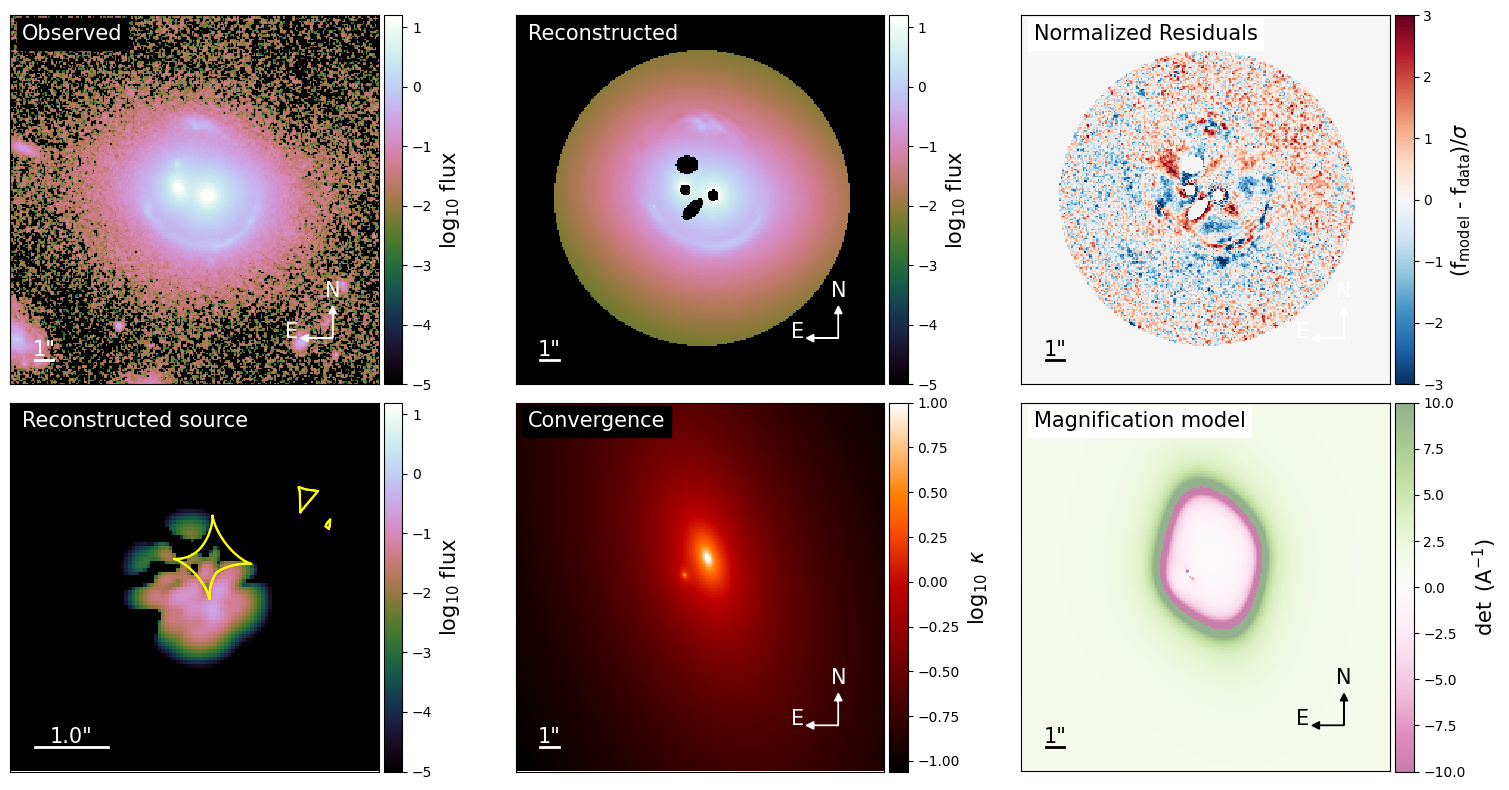

/opt/conda/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: divide by zero encountered in log10
  np.log10(model),
/opt/conda/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


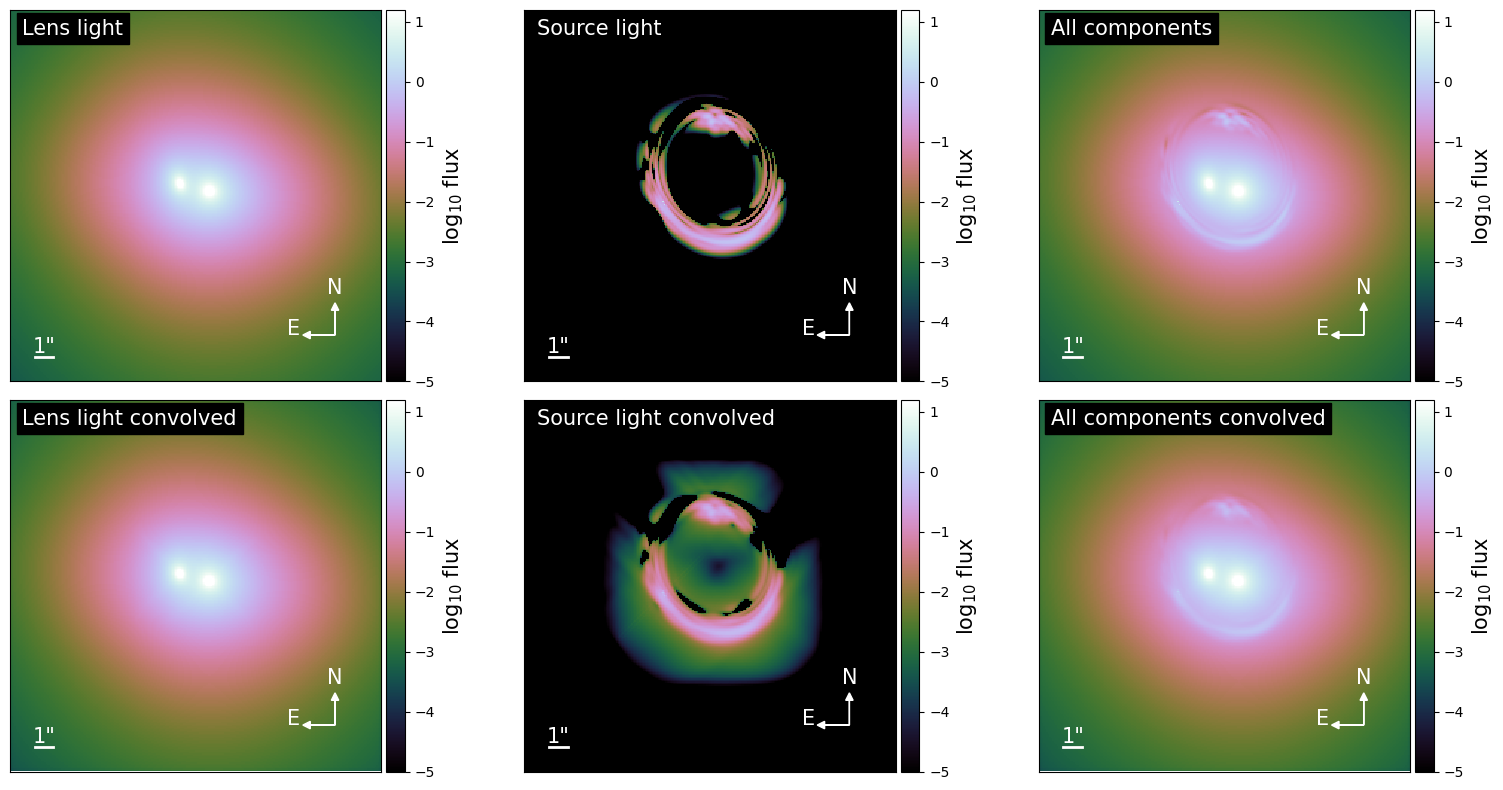

{'kwargs_lens': [{'theta_E': 3.0608740809091013, 'gamma': 2, 'e1': -0.2707782644778701, 'e2': 0.1748917823518985, 'center_x': -0.30305779033690367, 'center_y': 1.4689229099449619}, {'gamma1': -0.09962040120969, 'gamma2': 0.11470391635159805, 'ra_0': 0.0, 'dec_0': 0.0}, {'theta_E': 0.2372340855688097, 'e1': -0.12248823436620204, 'e2': 0.08089243563934403, 'center_x': 0.9475250365922168, 'center_y': 0.5461487335007825}], 'kwargs_source': [{'amp': 69313107.77511, 'R_sersic': 0.0015515309890571565, 'n_sersic': 1.0, 'e1': -0.4836094857845287, 'e2': 0.021194515030476674, 'center_x': -0.18699667507668677, 'center_y': 0.9209954495146544}, {'amp': array([ 1.05692952e+02, -1.96581496e+01, -7.85122525e+01,  7.05155416e+01,
        8.94007184e+00,  5.71656448e+01, -5.48548770e+01, -5.05273845e+01,
       -3.36304105e+01, -3.93700365e+01,  4.67924180e+01,  2.70926908e+01,
        4.15854545e+01,  3.93308286e+01,  2.85081264e+01, -7.95283781e+00,
       -1.09477208e+01, -3.62379711e+00, -2.61687833e

In [18]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.05, numPix=100, with_caustics=True, scale_size=1
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

In [19]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "DESIJ0136-0008_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## MCMC

In [20]:
mcmc_backend = "mcmc_backend.h5"

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": 0,
            "n_run": 800,
            "n_walkers": 200,
            "sigma_scale": 0.1,
            "threadCount": 3,
            "backend_filename": mcmc_backend,
            "start_from_backend": True,
        },
    ]
]


chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq.best_fit()

ValueError: Cannot have `initial_state=None` if run_mcmc has never been called.

## Trace Plots

In [ ]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

In [ ]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        samples_mcmc = chain_list_mcmc[k][1]

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 200
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

## Corner Plot

In [ ]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 1500
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

## MCMC: Visualizing the Fitted Model

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, numPix=100, with_caustics=True, scale_size=0.7
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

print(kwargs_result_mcmc)

## Mass and Light Ellipticity of the Lens Galaxy

In [ ]:
"""result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {}".format(
        mass_q,
        light_q,
    )
)"""

## Save the Best Fit Parameters (MCMC)

In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result_mcmc, multi_band_list_out, kwargs_fixed_out]

output_path = "DESIJ0136-0008_mcmc_output.joblib"
with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=9)